1. Persiapan Data awal Analisis Machine Learning Mangrove dan Land Cover

1.1 Upload data AOI wilayah analisis (Studi kasus Pulau Tobea Besar)
Membuat file .shp menggunakan software qgis pada wilayah Pulau Tobea Besar sebagai area of interst. kemudian mengupload file tersebut pada google drive

sebagai data referensi kami mengambil sumber data dari portal : https://geoportal.menlhk.go.id/portal/home/webmap/viewer.html?layers=71290d72e0ff4188a69d790fe5f1b2d9




In [1]:
#import libary geopandas
import geopandas as gpd

In [2]:
AOI = gpd.read_file('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/AOI.shp')

1.2 Download Sentinel-2 Data (GEEMAP)
Selanjutnya kita akan mempersiapkan data citra sentinel 2 untuk digunakan sebagai data dasar pengolahan kita, data sentinel 2 ini akan di gunakan untuk mengestrak data mangrove

untuk mendapatkan data citra sentinel 2 di google colab, kita akan menggunakan salah satu library tambahan yaitu "GEEMAP".

geemap adalah library Python yang dibuat untuk mempermudah kita menggunakan Google Earth Engine (GEE) di lingkungan Python, misalnya di Google Colab. Dengan geemap, kita bisa akses data Sentinel-2 secara gratis, olah, dan tampilkan hasilnya langsung di Google Colab, semua hanya dengan beberapa baris kode.

untuk dapat menggunakan fitur GEE dapat dilakukand dengan cara sebagai berikut :

*   Pergi ke link https://earthengine.google.com/noncommercial/
*   Pilih Get Started
*   Membuat project
*   Melakukan registrasi
*   Mengaktifkan api google earth




In [20]:
#import library geemap
!pip install pycrs
import ee
import geemap

In [4]:
#menghubungkan dengan google cloud GEE yang akan di gunakan
ee.Authenticate()
ee.Initialize(project='pelatihan-geemap')

In [7]:
# Menambahkan basemap
m = geemap.Map()
#memilih basemap
m.add('basemap_selector')
# Menambahkan Layer manager
m.add("layer_manager")
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

1.2.2 Mendapatkan data citra satelit dengan menggunakan GEEMAP



Langkah selanjutnya kita akan mencoba untuk mendapatkan data citra satelit yang akan kita gunakan untuk analisis mangrove dan tutupan lahan, dimana citra yang akan kita gunakan adalah citra sentinel-2, dan kita akan mendapatkan nya melalui catalog nya GEE, dan akan memanggil nya melalui google colab

Langkah pertama sebelum mendapatkan citra satelit nya adlah, kita harus menentukan batasan wilayah yang ingin kita ambil citra nya, oleh karena itu kita akan memasukan data SHP AOI wilayah kita dan mengubah nya menjadi earth engin object agar format nya bisa terbaca pada basemap GEE tersebut


In [9]:
#memasukan shapefile AOI dan mengubahnya kedalam earth engine object
AOI_ee = geemap.shp_to_ee('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/AOI.shp')
AOI_ee = AOI_ee.geometry()

In [10]:
AOI_ee

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection",
          "arguments": {
            "features": {
              "arrayValue": {
                "values": [
                  {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        "geometry": {
                          "functionInvocationValue": {
                            "functionName": "GeometryConstructors.Polygon",
                            "arguments": {
                              "coordinates": {
                                "constantValue": [
                                  [
                                    [
                                      122.685416526507,
                                      -4.508917427616906
                                    ],
                                    [
                                      122.76309897234934,
                                      -4.515453426079722
                                    ],
                                    [
                                      122.76230426702102,
                                      -4.6061590453951515
                                    ],
                                    [
                                      122.69137681646934,
                                      -4.614080387554355
                                    ],
                                    [
                                      122.66654227495965,
                                      -4.561797903013025
                                    ],
                                    [
                                      122.685416526507,
                                      -4.508917427616906
                                    ]
                                  ]
                                ]
                              },
                              "geodesic": {
                                "constantValue": false
                              }
                            }
                          }
                        },
                        "metadata": {
                          "constantValue": {
                            "id": 0
                          }
                        }
                      }
                    }
                  }
                ]
              }
            }
          }
        }
      }
    }
  }
})

In [11]:
#menambahkan AOI ke dalam peta geemap
m.addLayer(AOI_ee, {}, 'AOI')
m.centerObject(AOI_ee, 12) #set zoom in
m

Map(bottom=812.0, center=[-4.560615808140285, 122.71867753327318], controls=(WidgetControl(options=['position'…

**Mendapatkan & Mendownload citra satelit sentinel 2**

In [12]:
# Membuat variable S2_Col untuk memanggil image collection Sentinel-2
## referensi https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED?hl=id
S2_Col = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

In [13]:
# Proses pemfilteran data image collection
# Pemfilteran tutupan awan ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20) (hanya memilih data yg memiliki tutupan awan dibawah 20%)
# Pemfilteran tanggal ee.Filter.date('2023-01-01', '2023-12-31') (silahkan edit rentang tanggal)
# Filter berdasarkan wilayah kajian .filter(ee.Filter.bounds(AOI))
S2_filtered = S2_Col.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filter(ee.Filter.date('2024-01-01', '2024-12-31')).filter(ee.Filter.bounds(AOI_ee))
S2_filtered

In [14]:
# Setelah kita memfilter image collection
# Langkah selanjutnya adalah membuat median composite
# Berikut kita membuat median composite dengan fungsi .median()
# Setelah itu kita melakukan apply factor skala untuk data Sentinel-2, yaitu setiap nilai piksel dibagi dengan 10000 .divide(10000)
# Selanjutnya kita memotong data image sesuai dengan area kajian kita dengan fungsi .clip(AOI)
S2_medianComposite = S2_filtered.median().divide(10000).clip(AOI_ee)
S2_medianComposite



In [15]:
# Variable untuk visualisasi image
Vis_S2 = {
  "min": 0.0,
  "max": 0.2,
  "bands": ['B4', 'B3', 'B2'],
}

In [16]:
# Menambahkan data image ke peta
m.addLayer(S2_medianComposite, Vis_S2, "True color (432)")
m.centerObject(AOI_ee, 12) #Set zoom in
m

Map(bottom=1075484.0, center=[-4.560615808140285, 122.71867753327318], controls=(WidgetControl(options=['posit…

In [17]:
# Pilih band yang akan kita gunakan kedepannya.
# disini saya memilih band RED(B4), Green(B3), Blue (B2), NIR (B8), SWIR1(B11), dan SWIR2(B12)
selected_bands = S2_medianComposite.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
selected_bands



In [19]:
# Export dengan default WGS84 tanpa mendefinisikan CRS
geemap.ee_export_image_to_drive(selected_bands, description="S2_2024_tobea", folder="data", region=AOI_ee, scale=10)

Untuk melihat perkembangan export ke google drive. Kita bisa menggunakan Link: https://code.earthengine.google.com/tasks

1.3 Pengolahan Data Raster


Setelah kita mendapatkan data Sentinel-2 yang mencangkup wilayah kajian. Kita akan menggunakan data tersebut dalam sesi Rasterio ini. Library Rasterio adalah library yang umum digunakan untuk pengolahan data geospasial raster. Pada sesi kali ini kita akan mempelajari:

* Import raster data ke dalam Python
* Memahami data raster menggunakan Rasterio
* Visualisasi data raster



In [21]:
# install Library rasterio
!pip install rasterio

# Import Library rasterio
import rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 88.9 MB/s eta 0:00:00


In [22]:
# Membaca file raster .tif
# Sesuaikan lokasi path dari data raster yang sudah diexport dari GEE ke google drive kita
raster_file_path = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/S2_2024_tobea.tif'
dataset = rasterio.open(raster_file_path)

In [23]:
# Memeriksa jumlah band
num_bands = dataset.count
print('Total Bands: {n}\n'.format(n=num_bands))

Total Bands: 6



In [25]:
# Deskripsi list bands pada data
desc = dataset.descriptions

print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')



In [26]:
# Column dan row atau image size
rows, cols = dataset.shape
print('Image size: {r} rows x {c} columns\n'.format(r=rows, c=cols))


# Cek data projection
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

Image size: 1171 rows x 1076 columns

Image projection:
EPSG:4326 



In [27]:
# Menampilkan metadata
metadata = dataset.meta

print('Semua metadata:')
print(metadata)



Semua metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1076, 'height': 1171, 'count': 6, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 122.66647918250366,
       0.0, -8.983152841195215e-05, -4.508913905581114)}


**Visualisasi Citra Sentinel-2**


In [28]:
# Import library matplotlib untuk visualisasi data raster
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# untuk membuka semua band di data raster, kita bisa menggunakan
S2_image_all = dataset.read()
S2_image_all.shape

(6, 1171, 1076)

In [30]:
# Format shape dari data tersebut adalah bands, row, column (6, 1171, 1076)
# Untuk Plot data raster dengan matplotlib, kita harus menggunakan format shape row, column,bands
# Ubah format shape menjadi row, column, bands:
S2_image_all = S2_image_all.transpose(1, 2, 0)
S2_image_all.shape

(1171, 1076, 6)

In [31]:
# Deskripsi list bands pada data
desc = dataset.descriptions
print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')



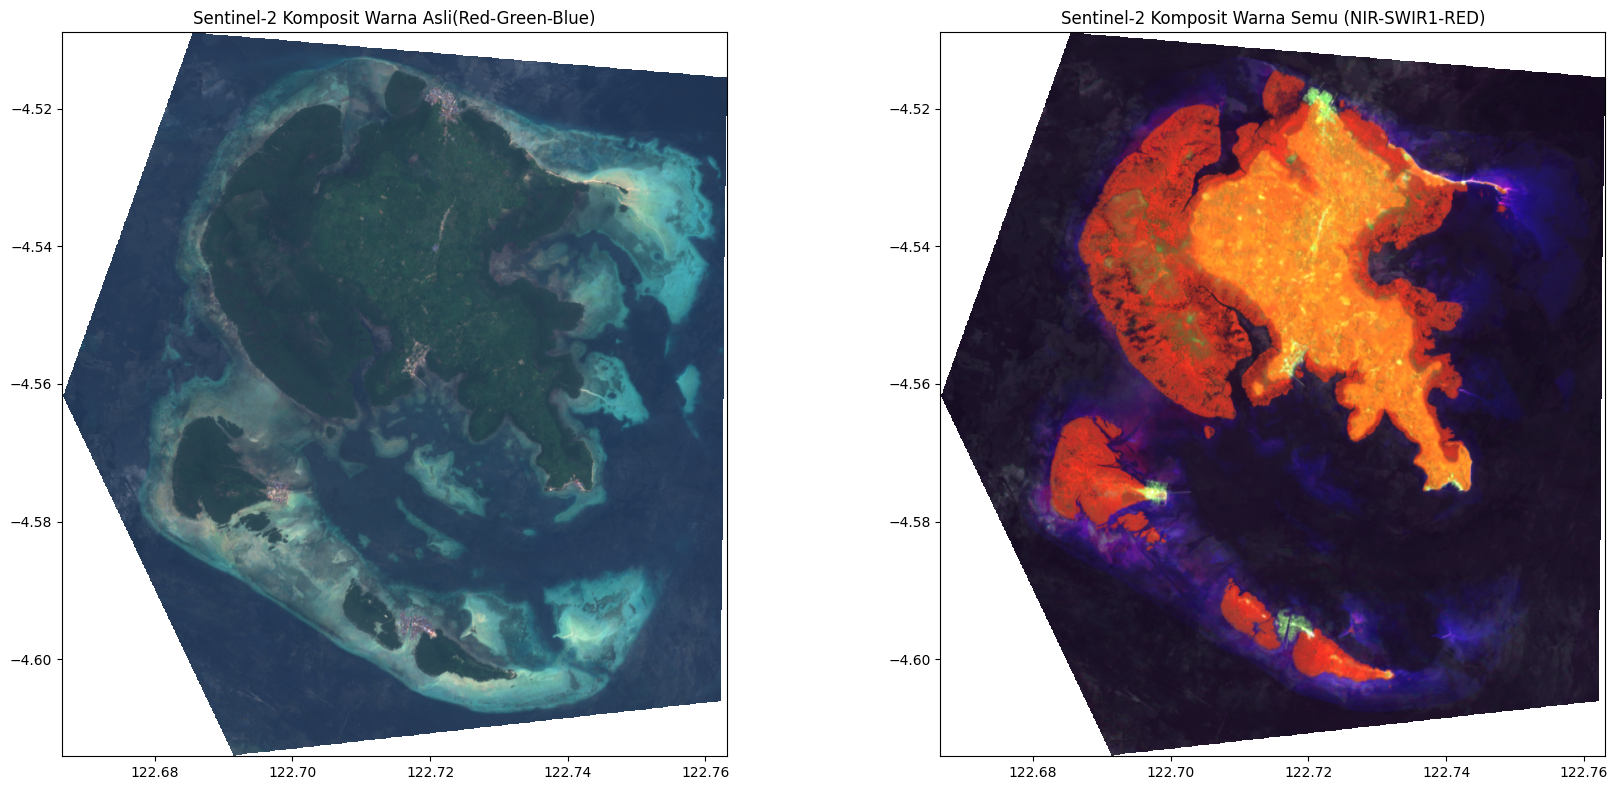

In [32]:
# Visualisasi Komposit warna asli (B4, B3, B2) dan komposit warna semu (B8, B11, B4)

# Membuat figure untuk dua plot gambar
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Untuk membuat visualisasi yang lebih cerah, silahkan atur brightness factor
brightness_factor = 3.5


# Original Sentinel-2 image (RGB)
rgb = np.stack((S2_image_all[:, :, 2], S2_image_all[:, :, 1], S2_image_all[:, :, 0]), axis=-1) #menggunakan stack untuk membuat komposit citra
S2_Vis_rgb = np.clip(rgb * brightness_factor, 0, 1)

ax[0].imshow(S2_Vis_rgb, extent=[AOI.total_bounds[0], AOI.total_bounds[2],AOI.total_bounds[1], AOI.total_bounds[3]])
ax[0].set_title('Sentinel-2 Komposit Warna Asli(Red-Green-Blue)')

# Komposit warna semu Sentinel-2 image (B8, B11, B4)
semu = np.stack((S2_image_all[:, :, 3], S2_image_all[:, :, 4], S2_image_all[:, :, 2]), axis=-1)
S2_Vis_semu = np.clip(semu * brightness_factor, 0, 1)

ax[1].imshow(S2_Vis_semu, extent=[AOI.total_bounds[0], AOI.total_bounds[2],AOI.total_bounds[1], AOI.total_bounds[3]])
ax[1].set_title('Sentinel-2 Komposit Warna Semu (NIR-SWIR1-RED)')

plt.tight_layout()
plt.show()

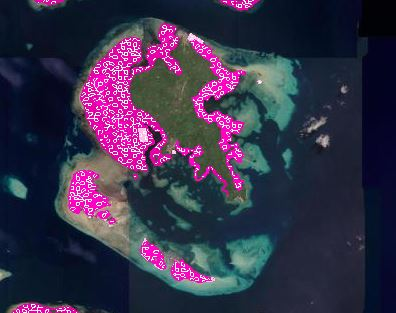

In [43]:
from google.colab import files
uploaded = files.upload()
from IPython.display import Image
Image('512eef27-e2a6-4aba-a14b-1b6bed4b198a_hd (1).jpg', width=800)

## sumber data https://geoportal.menlhk.go.id/portal/home/webmap/viewer.html?layers=71290d72e0ff4188a69d790fe5f1b2d9

sumber paper : Chen, Z., Zhang, M., Zhang, H. & Liu, Y. Mapping mangrove using a red-edge mangrove index (REMI) based on sentinel-2
multispectral images. IEEE Trans. Geosci. Remote Sens. 61, 1–11. https://doi.org/10.1109/TGRS.2023.3323741 (2023).


Makalah penelitian oleh Chen et al. (2023) memperkenalkan Red-Edge Mangrove Index (REMI), sebuah metode baru untuk memetakan hutan bakau menggunakan citra satelit Sentinel-2. Para penulis menggabungkan REMI dengan algoritma segmentasi ambang batas Otsu untuk mengidentifikasi distribusi bakau secara akurat di Pulau Hainan, Tiongkok.
Komponen utama REMI

    Formula: REMI menggunakan kombinasi empat pita spektral dari citra Sentinel-2 untuk menyoroti karakteristik kehijauan dan kelembapan yang khas dari vegetasi bakau:
    REMI = (red edge – red) / (SWIR1 – green)
    Pita yang digunakan:
        Merah (Red)
        Hijau (Green)
        Tepi merah (Red edge)
        Inframerah gelombang pendek 1 (SWIR1 - Short-Wave Infrared 1)
    Lokasi penelitian: Pulau Hainan, Tiongkok

**Feature Engineering dan Persiapan Data Training**

**2. Pemrosesan Sample Data**
2.1 Feature Extraction atau Pembuatan Spectral Index
Feature extraction merupakan istilah umum dalam analisis data maupun machine learning yang mengacu pada proses pembuatan fitur baru, pemilihan fitur penting, atau reduksi fitur yang sudah ada. Dalam konteks penginderaan jauh, feature sering kali diartikan sebagai “band”. Dengan demikian, feature extraction dalam konteks ini dapat diartikan sebagai proses penambahan informasi dari band-band tertentu yang akan digunakan sebagai data masukan.

Terdapat lima spectral index yang akan dibuat dan digunakan sebagai fitur tambahan dalam analisis, yaitu:

* NDVI (Normalized Difference Vegetation Index)

* NDBI (Normalized Difference Built-up Index)

* MNDWI (Modified Normalized Difference Water Index)

* NDMI (Normalized Difference Mangrove Index)

* CMRI (Combined Mangrove Recognition Index)


In [44]:
# install Library rasterio
!pip install rasterio

# Import Library yang dibutuhkan
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Membaca file raster .tif
# Sesuaikan lokasi path dari data raster yang sudah diexport dari GEE ke google drive kita
raster_file_path = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/S2_2024_tobea.tif'
dataset = rasterio.open(raster_file_path)



In [46]:
# untuk membuka semua band di data raster, kita bisa menggunakan
S2_image_all = dataset.read()
S2_image_all.shape

(6, 1171, 1076)

In [47]:
# Bisa kita lihat, format shape dari data tersebut adalah bands, row, column (6, 1171, 1076)
# Untuk Plot data raster dengan matplotlib, kita harus menggunakan format shape row, column,bands
# Ubah format shape menjadi row, column, bands:
S2_image_all = S2_image_all.transpose(1, 2, 0)
S2_image_all.shape

(1171, 1076, 6)

In [48]:
# Deskripsi list bands pada data
desc = dataset.descriptions

print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')



In [49]:
## fungsi untuk membuat berbagai spectral index sekaligus
def calculate_spectral_indices(S2_image_all):
    # Extract bands dari S2_image_all
    blue = S2_image_all[:, :, 0]   # B2
    green = S2_image_all[:, :, 1]  # B3
    red = S2_image_all[:, :, 2]    # B4
    nir = S2_image_all[:, :, 3]    # B8
    swir1 = S2_image_all[:, :, 4]  # B11
    swir2 = S2_image_all[:, :, 5]  # B12

    # NDVI: (NIR - Red) / (NIR + Red)
    NDVI = (nir - red) / (nir + red)

    # NDBI: (SWIR1 - NIR) / (SWIR1 + NIR)
    NDBI = (swir1 - nir) / (swir1 + nir)

    # MNDWI: (Green - SWIR1) / (Green + SWIR1)
    MNDWI = (green - swir1) / (green + swir1)

    # NDMI: (SWIR2 - Green) / (SWIR2 + Green)
    NDMI = (swir2 - green) / (swir2 + green)

    # CMRI: NDVI - NDWI
    NDWI = (green - nir) / (green + nir)
    CMRI = NDVI - NDWI

    # Stack spectral indices
    spectral_indices = np.stack([NDVI, NDBI, MNDWI, NDMI, CMRI], axis=-1)

    # Concatenate atau menggabungkan original bands dengan the spectral indices
    S2_image_with_indices = np.concatenate((S2_image_all, spectral_indices), axis=-1)

    return S2_image_with_indices

In [50]:
# Membuat input data dengan 11 bands: 6 original bands dan 5 spectral indices
S2_image_with_indices = calculate_spectral_indices(S2_image_all)
print(S2_image_with_indices.shape)

(1171, 1076, 11)


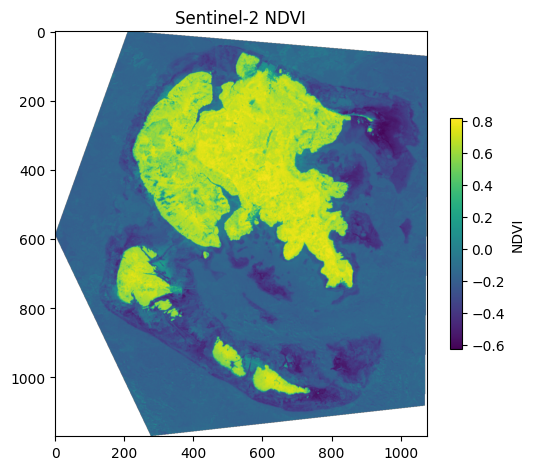

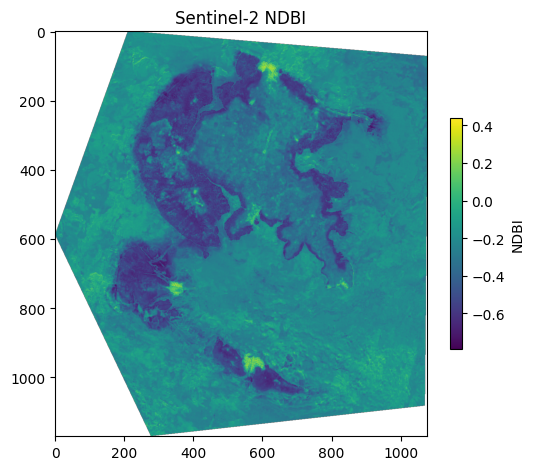

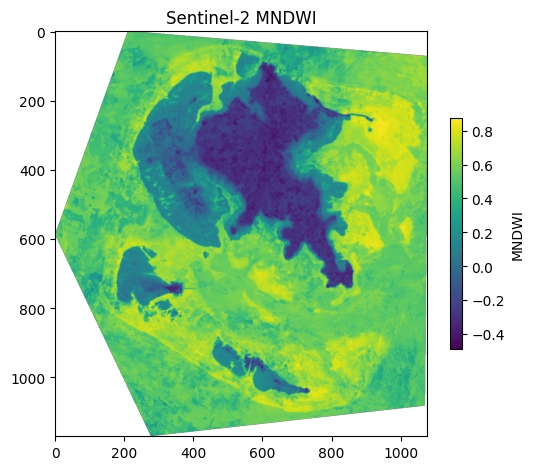

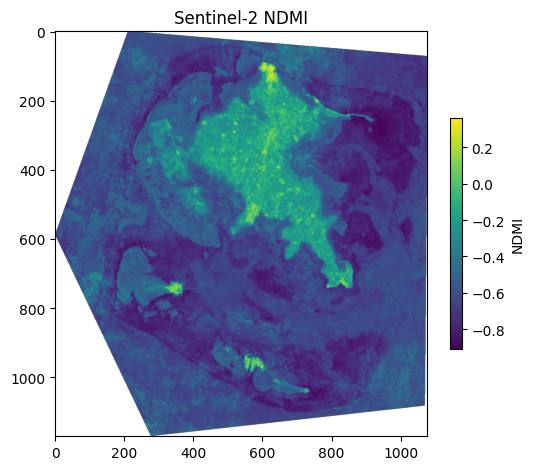

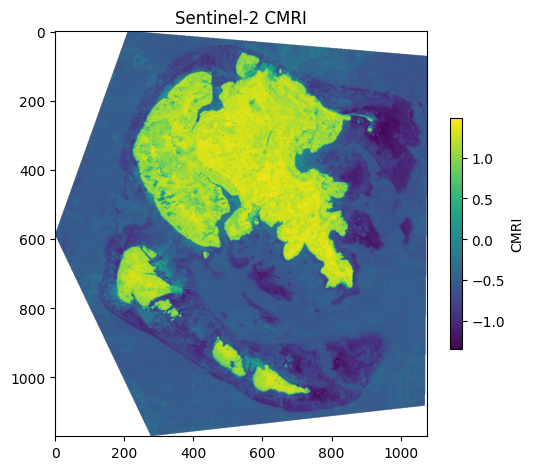

In [51]:
# List nama spectral index
spectral_index_names = ['NDVI', 'NDBI', 'MNDWI', 'NDMI', 'CMRI']

# Start index untuk NDVI adalah index ke 6
start_index = 6

# Loop untuk semua spectral index dan plot semuanya
for i, index_name in enumerate(spectral_index_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(S2_image_with_indices[:, :, start_index + i], cmap='viridis')
    plt.colorbar(label=index_name, shrink=0.5)
    plt.title(f'Sentinel-2 {index_name}')
    plt.show()

In [52]:
## Menyimpan Citra Sentinel-2 Baru yang sudah terdapat spectral index didalamnya dengan total 11 bands
# langkah pertama adalah untuk mendapatkan metadat dari original dataset
meta = dataset.meta.copy()

# Kemudian memperbaharui meta data karena kita memiliki 11 bands
meta.update({
    "count": 11,  # 6 orignal bands + 5 spectral index
    "dtype": 'float32',  # Set the data type to float32
    "driver": 'GTiff'  # Save as GeoTIFF
})

meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1076,
 'height': 1171,
 'count': 11,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.983152841195215e-05, 0.0, 122.66647918250366,
        0.0, -8.983152841195215e-05, -4.508913905581114)}

In [53]:
# Mendefiniskan deskripsi nama bands (original bands + spectral indices)
band_descriptions = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12',
                     'NDVI', 'NDBI', 'MDNWI', 'NDMI', 'CMRI']

# Tempat untuk menyimpan file tif.
output_file_path_S2New = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/S2_with_SpectralIndices.tif'

# Export Sentinel-2 dengan sepctral indices
with rasterio.open(output_file_path_S2New, 'w', **meta) as dst:
    for i in range(11):
        dst.write(S2_image_with_indices[:, :, i], i + 1)  # Write each band

        # Menambahkan deskripsi band names untuk setiap bands
        dst.set_band_description(i + 1, band_descriptions[i])

In [54]:
# Verifikasi hasil export
with rasterio.open(output_file_path_S2New) as dataset2:
    desc = dataset2.descriptions
    print('Raster description: {desc}\n'.format(desc=desc))

Raster description: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDBI', 'MDNWI', 'NDMI', 'CMRI')



**Pemrosesan Sample Data**

2.2 Input nilai sampel dan ekstraksi nilai sampel

karena kita akan menggunakan Supervised Learning - XGboost maka kita perlu membuat sample data. proses pembuatan sample data atau digitasi dilakukan secara manual menggunakan software qgis.

proses pembuatan titik sampel dilakukan melalui interpretasi visual dengan lima
kelas penutup lahan, yaitu:
* Tubuh air
* Vegetasi non mangrove
* Mangrove
* Lahan terbangun
* Lahan terbuka

In [1]:
from google.colab import files
uploaded = files.upload()


Saving titik_sample.JPG to titik_sample.JPG


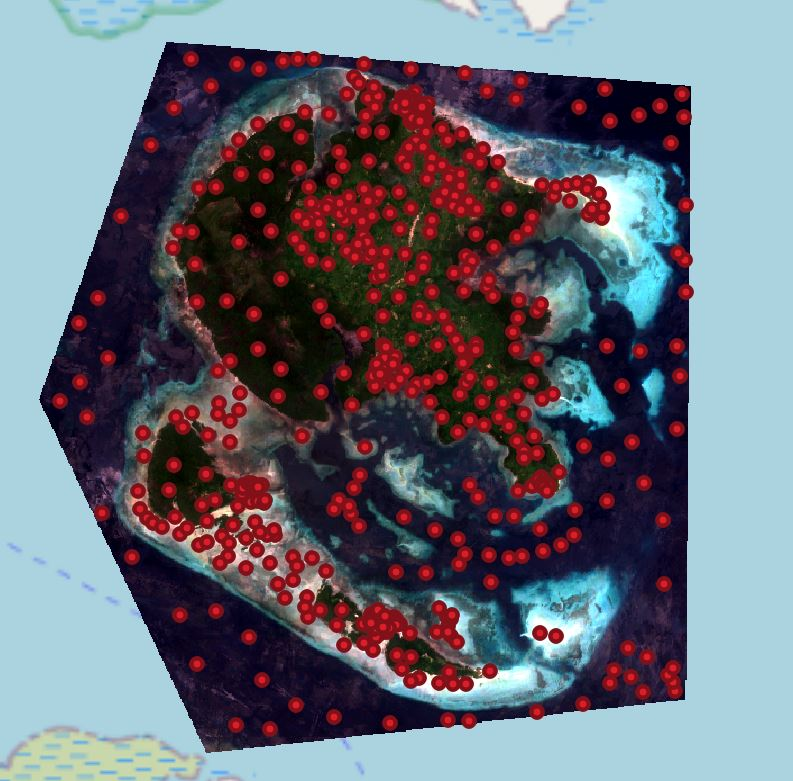

In [2]:
from IPython.display import Image
Image('titik_sample.JPG', width=800)

In [3]:
!pip install rasterio
# Library yang dibutuhkan:
from rasterio.mask import mask
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 65.1 MB/s eta 0:00:00


In [5]:
# Memanggil data shapefile point sampel
point_sample = gpd.read_file('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/sample_data_tobea2014.shp')
point_sample.head()



id                    geometry
0   0  POINT (122.76084 -4.60507)
1   0  POINT (122.76058 -4.60367)
2   0   POINT (122.7599 -4.60269)
3   0  POINT (122.76059 -4.60162)
4   0  POINT (122.75617 -4.60517)

In [6]:
# Mengetahui total sample pada setiap kelas:
print(point_sample['id'].value_counts())


# Membuka data Sentinel-2 yang sudah terdapat spectral indexnya
raster_input = rasterio.open('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/S2_with_SpectralIndices.tif')

num_bands = raster_input.count
print('Total Bands: {n}\n'.format(n=num_bands))



id
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64
Total Bands: 11



In [7]:
# Mengecek terlebih dahulu apakah CRS dari data point sample dan raster sama
# Apabila tidak sama maka CRS data point sample akan disamakan dengan CRS raster
if point_sample.crs != raster_input.crs:
    print("CRS berbeda, menyesuaikan CRS point sample dengan CRS raster...")
    point_sample = point_sample.to_crs(raster_input.crs)
    print("CRS point sample setelah disesuaikan:", point_sample.crs)
else:
    print("CRS point sample dan raster sudah sama.")

CRS point sample dan raster sudah sama.


In [8]:
## Membuat Fungsi Untuk Extract Pixel Raster Value dari data Shapefile
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['id']

        # Mask raster untuk mendapatkan pixel values yang terdapat dalam geometry shapefile
        out_image, out_transform = mask(raster, geometry, crop=True)

        # out_image shape: (bands, height, width) -- Reshape menjadi (pixels, bands)
        out_image = out_image.reshape(raster.count, -1).T  # Sekarang (pixels, bands)

        # menghapus Nan Pixels (Jika ada piksel dalam suatu band bernilai NaN)
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]

        # Menambahkan valid pixel sebagai feature bersamaan dengan kelas labelnya
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))

    # Converts the tuple list kedalam numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels

In [9]:
# Menggunakan funtion extract pixel values yang sudah dibuat untuk mendapatkan fatures dan label:
features, labels = extract_pixels_from_shapefile(point_sample, raster_input)

# Cek shape dari features dan labels
print(features.shape)
print(labels.shape)

## Kita lihat, feature terdapat 11 bands sedangkan labels hanya mewakili kelas label saja

(500, 11)
(500,)


In [10]:
#Final Pre-Processing sampel data
# Membuat mask untuk cek Nan values dari feature dan label
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)

# Apabila ada Nan value maka akan dihapuskan
features = features[~nan_mask]
labels = labels[~nan_mask]

# Menghitung final total sampel masing-masing kelas
sample_new = pd.DataFrame({'class': labels})
print(sample_new['class'].value_counts())

class
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64


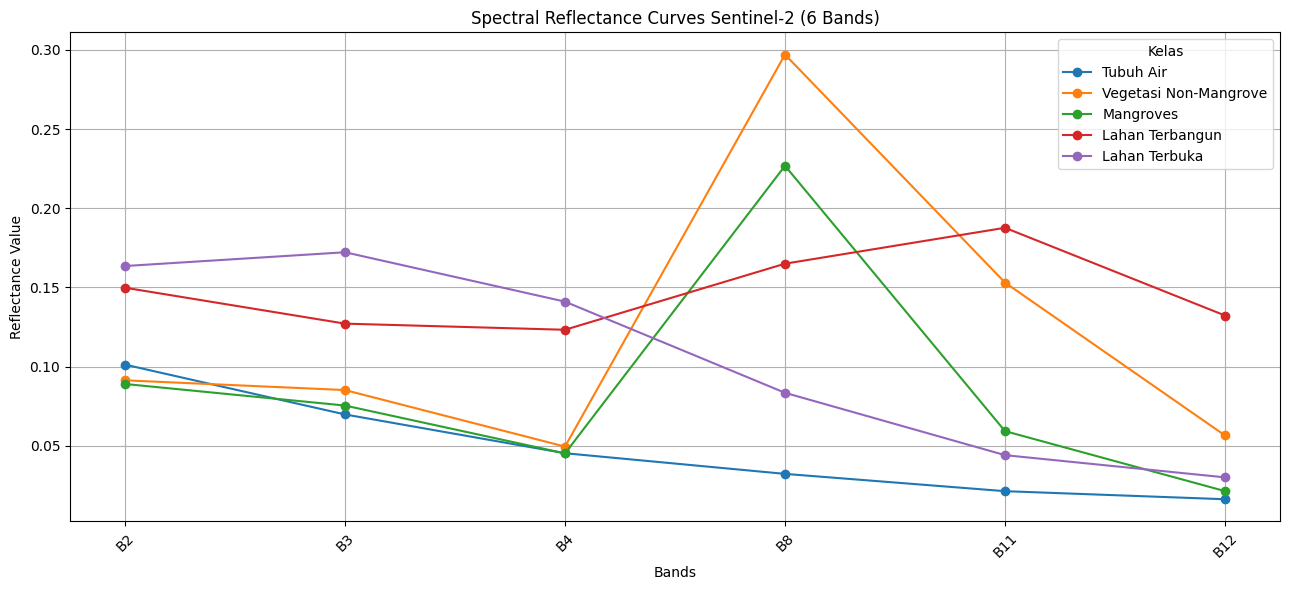

In [11]:
## Membuat Spectral Reflectance Curves setiap kelas pada 6 original bands
# Mendefiniskan band yang akan digunakan dan nama kelasnya
band_list = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
nama_kelas = ['Tubuh Air', 'Vegetasi Non-Mangrove', 'Mangroves', 'Lahan Terbangun', 'Lahan Terbuka']

# Memilih 6 bands pertama dari variable features
features_6_bands = features[:, :6]

# Plotting figure
plt.figure(figsize=(13, 6))

# Menggunakan Loop untuk setiap kelas dan menghitung nilai rata2 untuk setiap bands
for class_id in range(5):
    # Memilih frature yang sesuai dengan kelasnya
    class_features = features_6_bands[labels == class_id]

    # menghitung nilai rata2 setiap kelas dari seluruh bands
    mean_reflectance = np.mean(class_features, axis=0)

    # Plot spectral curves untuk setiap kelas
    plt.plot(band_list, mean_reflectance, label=nama_kelas[class_id], marker='o')

# Menambahkan title dan label
plt.title('Spectral Reflectance Curves Sentinel-2 (6 Bands)')
plt.xlabel('Bands')
plt.ylabel('Reflectance Value')
plt.legend(title='Kelas')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Membuat Training dan testing Data**

In [12]:
from sklearn.model_selection import train_test_split

# Split data: 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=69)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 11) (100, 11) (400,) (100,)


In [13]:
# Menyimpan numpy X_train, X_test, y_train, and y_test kedalam folder data GOC2 untuk digunakan Minggu depan
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/X_train.npy', X_train)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/X_test.npy', X_test)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/y_train.npy', y_train)
np.save('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/y_test.npy', y_test)
